## Дипломный проект "Аналитика. Средний уровень".

Выпонил: Денис Усалёв.<br>
usalev@gmail.com<br>
http://github.com/dulti

В ходе опроса компания «Мегафон» предложила своим клиентам оценить уровень удовлетворённости качеством связи по десятибалльной шкале (где 10 — это «отлично», а 1 — «ужасно»). Если клиент оценивал качество связи на 9 или 10 баллов, опрос заканчивался. Если клиент ставил оценку ниже 9, задавался второй вопрос — о причинах неудовлетворённости качеством связи с предоставленными пронумерованными вариантами ответа. Ответ можно было дать в свободном формате или перечислить номера ответов через запятую.

![Структура вопросов](https://sun9-32.userapi.com/C6vN5pHQW7hlseIt0AtTN7qNDQbDnHXdt1P2NA/ILntXqa-RrA.jpg)

### Часть 1. Загрузка и очистка данных.

Для начала, загрузим необходимые библиотеки и загрузим данные в память.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dtale
%matplotlib inline

import scipy as sc
from sklearn.preprocessing import MultiLabelBinarizer

from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('megafon.csv', index_col='user_id')
df.head()

,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
user_id,,,,,,,,,,
1,5,NaN,775.48846,360.13,86.56,3.93,1859.15,2309,1007.82,83
2,5,4,861.96324,3023.54,411.18,1.27,667.47,2080,255.36,425
3,1,4,261.11860,790.96,34.20,1.79,1079.60,6367,535.85,485
4,8,3,179.18564,2590.97,325.88,0.80,7053.81,3218,1221.02,51
5,2,"2, 3, 4",351.99208,731.61,223.54,1.15,4550.38,1767,2336.56,68


In [3]:
# сохраним список колонок для дальнейшего использования
all_columns = df.columns.values
data_columns = all_columns[~np.isin(all_columns, ['Q1', 'Q2'])]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3112 entries, 1 to 3112
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Q1                                         3110 non-null   object 
 1   Q2                                         1315 non-null   object 
 2   Total Traffic(MB)                          3112 non-null   float64
 3   Downlink Throughput(Kbps)                  3112 non-null   float64
 4   Uplink Throughput(Kbps)                    3112 non-null   float64
 5   Downlink TCP Retransmission Rate(%)        3112 non-null   float64
 6   Video Streaming Download Throughput(Kbps)  3112 non-null   float64
 7   Video Streaming xKB Start Delay(ms)        3112 non-null   int64  
 8   Web Page Download Throughput(Kbps)         3112 non-null   float64
 9   Web Average TCP RTT(ms)                    3112 non-null   int64  
dtypes: float64(6), int64(2),

Ответы на вопросы 1 и 2 приведены в столбцах `Q1` и `Q2` соответственно.<br>
Мы видим, что в столбце `Q2` есть пропущенные значения. Это неудивительно: согласно логике опроса, если респондент давал ответ "9" или "10" на первый вопрос, второй вопрос ему не задавали.<br>
Однако в столбце `Q1` есть два пропущенных значения. Посмотрим на них.

In [5]:
df[df['Q1'].isna()]

,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
user_id,,,,,,,,,,
372,NaN,NaN,286.62191,2320.25,75.60,3.84,4499.92,1790,1035.64,200
3027,NaN,NaN,875.62280,7258.66,226.08,0.60,8336.42,1087,3112.83,54


Это либо ошибки записи ответов, либо пользователи не дали никакого ответа. Избавимся от этих двух записей.

In [6]:
df = df.dropna(subset=['Q1'], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3110 entries, 1 to 3112
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Q1                                         3110 non-null   object 
 1   Q2                                         1315 non-null   object 
 2   Total Traffic(MB)                          3110 non-null   float64
 3   Downlink Throughput(Kbps)                  3110 non-null   float64
 4   Uplink Throughput(Kbps)                    3110 non-null   float64
 5   Downlink TCP Retransmission Rate(%)        3110 non-null   float64
 6   Video Streaming Download Throughput(Kbps)  3110 non-null   float64
 7   Video Streaming xKB Start Delay(ms)        3110 non-null   int64  
 8   Web Page Download Throughput(Kbps)         3110 non-null   float64
 9   Web Average TCP RTT(ms)                    3110 non-null   int64  
dtypes: float64(6), int64(2),

Поле `Q1` имеет тип `object` - очевидно, в ответах есть что-то еще, кроме чисел от 1 до 10. Посмотрим на все варианты ответов, данные пользователями.

In [7]:
df['Q1'].value_counts()

10                                                                      846
1                                                                       532
3                                                                       325
8                                                                       291
9                                                                       238
5                                                                       234
7                                                                       200
2                                                                       168
4                                                                       123
6                                                                       101
0                                                                        10
Нет                                                                       2
Да                                                                        2
1, 3        

Мы видим, что помимо разрешенных значений от 1 до 10, у нас есть еще несколько групп значений. Какие это группы и что мы с ними можем сделать?
- Ответ с числом и с дополнительным комментарием. Возьмем у такого ответа только число.
- Ответ 0: вероятно, должен означать очень низкую оценку. Приравняем его к 1.
- Ответы "Нет" и "Да". Не представляется возможным установить, что именно хотели сказать эти респонденты, т.к. невозможно быть на 100% уверенными, соотвествует ли "Да" самой высокой оценке (например, "Удовлетворены ли вы качеством связи"), или "Нет" ("Есть ли у вас замечания по качеству связи"), поэтому выбросим эти ответы.
- Ответы с двумя и более оценками, например, когда пользователь дает две оценки качеству связи в зависимости от места оказания услуг. В этом случае можно выбросить такие ответы, однако мы сделаем по-другому: возьмем среднее между этими двумя или тремя оценками.
- Остальные ответы выбросим, т.к. из них невозможно извлечь оценку.

In [8]:
df['Q1_extr'] = df['Q1'].str.findall(r'([0-9]+)+')

In [9]:
def process_Q1(rat_list):
    """
    Обработка столбца с ответами согласно вышеприведенным правилам.
    После обработки в столбце остаются только значения от 1 до 10,
    а также значение '-1', которое мы потом выбросим.
    """
    total_sum = 0
    meaningful = 0
    for rating in rat_list:
        try:
            rating = int(rating)
        except:
            raise ValueError('The value cannot be converted to int')
        if 10 < rating < 21:
            total_sum += 10
            meaningful += 1
        elif 0 < rating <= 10:
            total_sum += rating
            meaningful += 1
        elif rating == 0:
            total_sum += 1
            meaningful += 1
    if meaningful == 0:
        return -1
    return int(np.floor(total_sum / meaningful))

df['Q1'] = df['Q1_extr'].apply(process_Q1)
df = df.drop(df[df['Q1'] == -1].index, axis=0)
df = df.drop('Q1_extr', axis=1)

In [10]:
# сохраним список колонок с данными + колонка 'Q1'
q1_columns = all_columns[all_columns != 'Q2']

In [11]:
Q2_text = ['Недозвоны, обрывы при звонках', 'Время ожидания гудков при звонке', 
           'Плохое качество связи в зданиях, торговых центрах и т.п.', 
           'Медленный мобильный интернет', 'Медленная загрузка видео', 
           'Затрудняюсь ответить', 'Свой вариант']

Теперь посмотрим, какие значения есть для второго вопроса.

In [12]:
df['Q2'].value_counts()

3                   190
4                   170
1                   168
1, 3                121
3, 4                 85
1, 3, 4              76
7                    64
1, 4                 56
3, 4, 5              45
1, 2, 3              44
1, 3, 4, 5           40
4, 5                 30
1, 4, 5              27
1, 2, 3, 4, 5        27
1, 2                 22
1, 2, 3, 4           18
2, 3                 12
1, 2, 4              11
2                    11
2, 3, 4              11
6                    10
5                     9
3, 5                  8
1, 5                  7
2, 4                  4
1, 2, 3, 5            4
1, 2, 4, 5            4
3, 4, 5, 7            3
1, 2, 5               3
2, 3, 4, 5            3
1, 3, 5               3
1, 4, 7               3
1, 3, 4, 7            2
3, 7                  2
1, 3, 7               2
3, 4, 7               2
2, 4, 5               2
1, 3, 4, 5, 7         2
1, 2, 3, 4, 5, 6      2
0, 1, 7               1
0                     1
4, 7            

Здесь тоже нужна предобработка. Закодируем каждый вопрос отдельно, в виде своего рода one-hot кодирования. Для этого сначала преобразуем все валидные значения в список, а затем с помощью класса `MultiLabelBinarizer` из пакета `sklearn` преобразуем значения таким образом, что каждому ответу на вопрос будет соответствовать своя колонка со значениями 0 (не отметил этот ответ) или 1 (отметил этот ответ).

In [13]:
def process_Q2(ans_list):
    """
    Преобразовываем значения второго вопроса в список, если они попадают в диапазон от 1 до 7.
    """
    try:
        if np.isnan(ans_list):
            return [-1]
    except TypeError:
        new_list = []
        for answer in ans_list:
            try:
                answer = int(answer)
            except:
                raise ValueError('The value cannot be converted to int')
            if 0 < answer < 8:
                new_list.append(answer)
    if len(new_list) == 0:
        return [-1]
    return new_list

df['Q2'] = df['Q2'].str.split(',').apply(process_Q2)

In [14]:
mlb = MultiLabelBinarizer()
q2_dummies = mlb.fit_transform(df['Q2'])
q2_only_columns = np.char.add('Q2_', mlb.classes_.astype('str'))
df = pd.merge(df, pd.DataFrame(q2_dummies, columns=q2_only_columns, index=df.index).drop('Q2_-1', axis=1), left_index=True, right_index=True)
q2_only_columns = q2_only_columns[q2_only_columns != 'Q2_-1']
# отдельно сохраним названия колонок с данными + ответы на 2й вопрос.
q2_columns = np.hstack([q2_only_columns, data_columns])
df = df.drop('Q2', axis=1)

In [15]:
df.head()

,Q1,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms),Q2_1,Q2_2,Q2_3,Q2_4,Q2_5,Q2_6,Q2_7
user_id,,,,,,,,,,,,,,,,
1,5,775.48846,360.13,86.56,3.93,1859.15,2309,1007.82,83,0,0,0,0,0,0,0
2,5,861.96324,3023.54,411.18,1.27,667.47,2080,255.36,425,0,0,0,1,0,0,0
3,1,261.11860,790.96,34.20,1.79,1079.60,6367,535.85,485,0,0,0,1,0,0,0
4,8,179.18564,2590.97,325.88,0.80,7053.81,3218,1221.02,51,0,0,1,0,0,0,0
5,2,351.99208,731.61,223.54,1.15,4550.38,1767,2336.56,68,0,1,1,1,0,0,0


Отлично, наши вопросы закодированы в удобной форме.

### Часть 2. EDA.

Перейдем к разведочному анализу. Сначала посмотрим на краткую инфрмацию о наших данных.

In [16]:
df.describe()

,Q1,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms),Q2_1,Q2_2,Q2_3,Q2_4,Q2_5,Q2_6,Q2_7
count,3093.000000,3093.000000,3093.000000,3093.000000,3093.000000,3093.000000,3093.000000,3093.000000,3093.000000,3093.000000,3093.000000,3093.000000,3093.000000,3093.000000,3093.000000,3093.000000
mean,6.012286,405.873036,2213.477388,170.701335,1.837617,5724.819066,2109.443582,2099.798807,194.156806,0.209182,0.059489,0.227934,0.202069,0.071775,0.004203,0.027805
std,3.465480,220.552326,2616.726012,204.521352,2.078479,5146.643142,1585.435943,2063.485125,267.860945,0.406790,0.236576,0.419568,0.401608,0.258157,0.064705,0.164440
min,1.000000,100.026680,13.260000,6.110000,0.050000,0.000000,239.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,213.918400,652.020000,70.560000,0.720000,2322.760000,1283.000000,1017.710000,74.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,363.550690,1400.570000,119.350000,1.300000,4433.610000,1673.000000,1671.210000,118.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,572.096340,2821.920000,210.610000,2.240000,7614.260000,2312.000000,2519.500000,206.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,887.078270,39817.640000,4141.850000,31.200000,58566.030000,21392.000000,35603.970000,3471.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Понятно, что по ответам на вопросы никаких сюрпризов нет: значения либо от 1 до 10 для первого вопроса, либо 0 или 1 для всех ответов на второй вопрос. Мы посмотрим распределение по ответам чуть позднее. Пока же займемся данными по абонентам.<br>
Первое, на что мы можем обратить внимание: для всех фактических данных сильно отличаются среднее и медиана, а также видна большая разница между значением 75-го процентиля и максимальным значением. Это говорит о том, что распределение сильно скошено вправо. Проверим, построив графики.

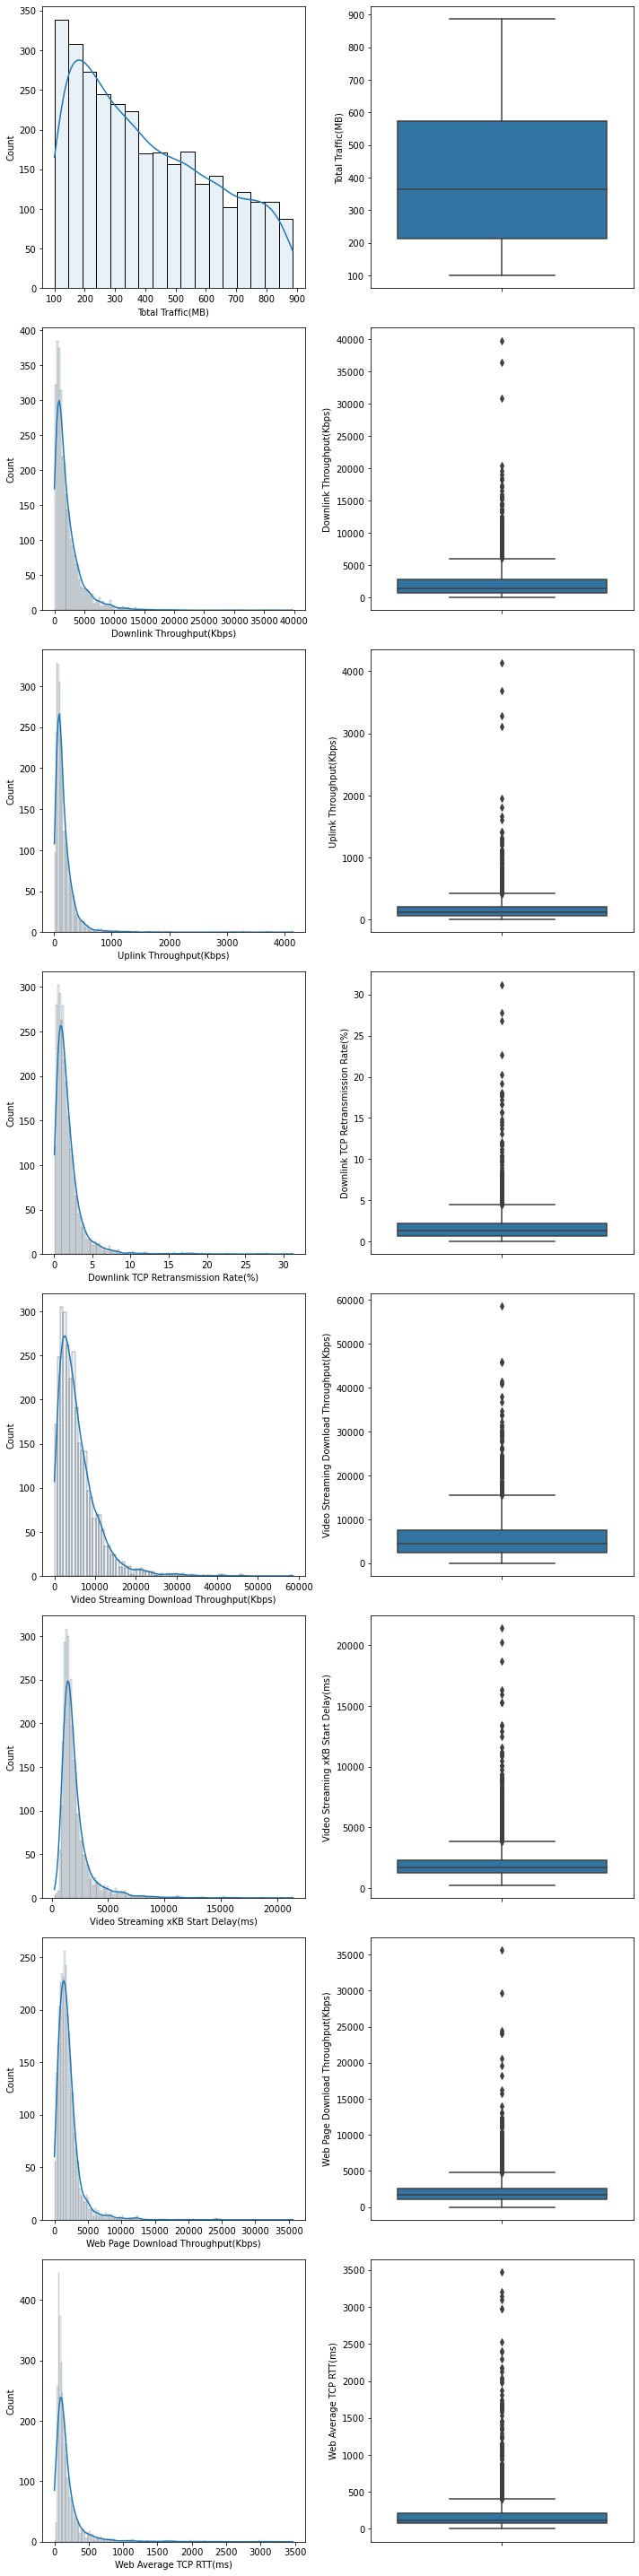

In [17]:
fig, ax = plt.subplots(len(data_columns), 2, figsize=(10, 40))
for idx, col in enumerate(data_columns):
    sns.histplot(data=df, x=col, ax=ax[idx][0], kde=True, alpha=0.1)
    sns.boxplot(data=df, y=col, ax=ax[idx][1])
fig.tight_layout()

Наша догадка подтвердилась. Однако по первой колонке (количество переданных данных за неделю) форма распределения сильно отличается от остальных переменных.<br>
Оставим пока первую колонку. <br>
Распределение данных по остальным переменным намекает на логнормальное распределение данных. Действительно, все признаки на месте: значения этих переменных положительны, распределение сильно скошено вправо с очень длинным хвостом и большим количеством выбросов.<br>
Возьмем логарифм и построим данные еще раз.

In [18]:
df[data_columns[1:]] += np.finfo(float).eps # добавляем machine epsilon, т.к. в данных могут быть нули
data_columns_log = [col + '_log' for col in data_columns[1:]]
df[data_columns_log] = df[data_columns[1:]].apply(np.log)

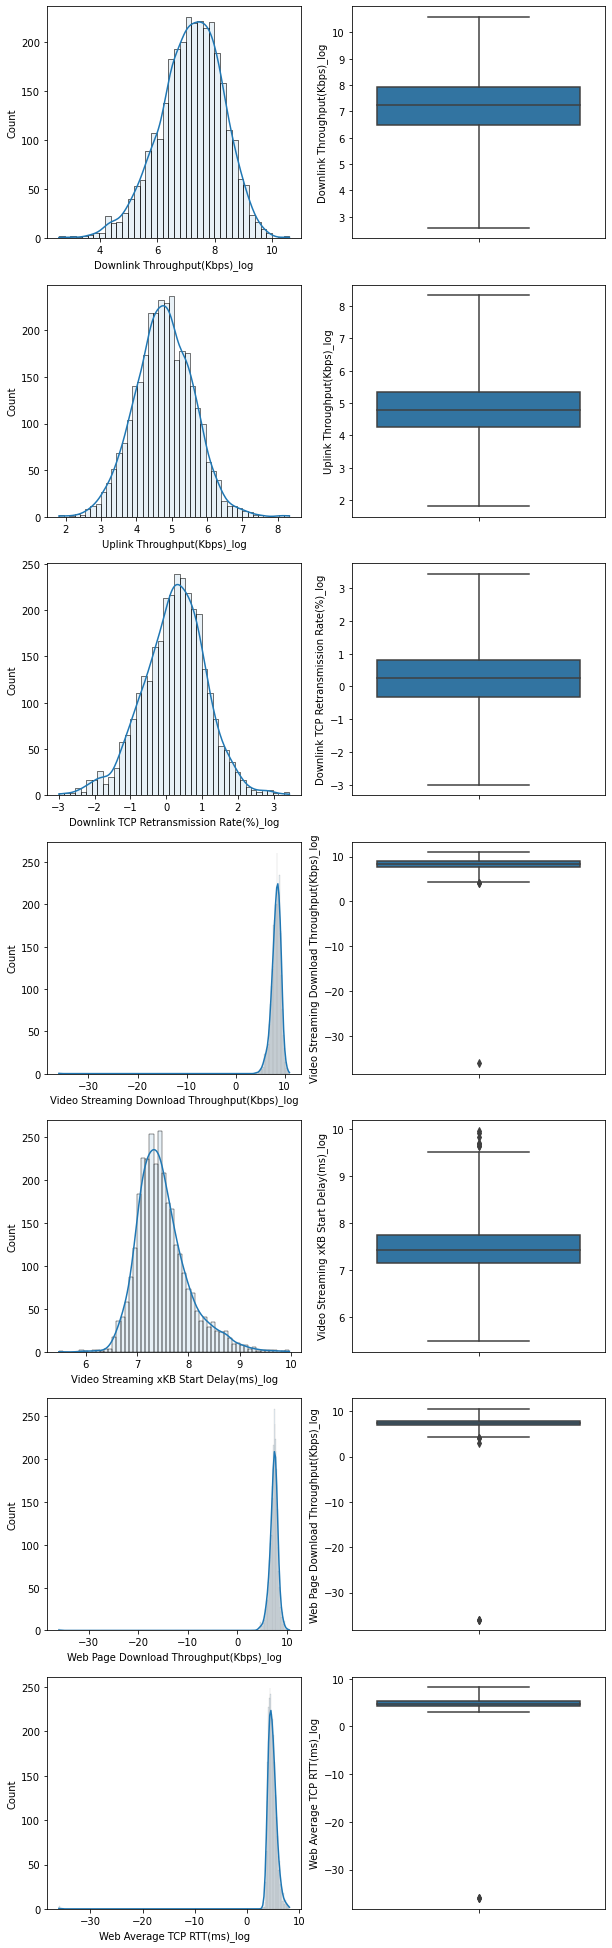

In [19]:
fig, ax = plt.subplots(len(data_columns_log), 2, figsize=(10, 35))
for idx, col in enumerate(data_columns_log):
    sns.histplot(data=df, x=col, ax=ax[idx][0], kde=True, alpha=0.1)
    sns.boxplot(data=df, y=col, ax=ax[idx][1], whis=3)

Действительно, распределение очень похоже на нормальное, однако для трех из семи переменных все равно остались выбросы (но уже гораздо меньше, чем у изначального распределения!). Уберем выбросы, оставив значения в пределах трех межквартильных расстояний от первого и третьего квартилей.

In [20]:
iqrs_log = {col: (np.exp(df[col_log].quantile(.25) - (df[col_log].quantile(.75) - df[col_log].quantile(.25)) * 3),
                  np.exp(df[col_log].quantile(.75) + (df[col_log].quantile(.75) - df[col_log].quantile(.25)) * 3)) 
            for col_log, col in zip(data_columns_log, data_columns[1:])}

In [21]:
# выведем получившиеся значения (это не логарифм, а изначальные значения!)
iqrs_log

{'Downlink Throughput(Kbps)': (8.042842739357644, 228768.40167422578),
 'Uplink Throughput(Kbps)': (2.6533670036724546, 5600.673250037326),
 'Downlink TCP Retransmission Rate(%)': (0.023910349854227436,
  67.4519615912208),
 'Video Streaming Download Throughput(Kbps)': (65.93776872210867,
  268224.09827267803),
 'Video Streaming xKB Start Delay(ms)': (219.2517842272433,
  13529.176104334854),
 'Web Page Download Throughput(Kbps)': (67.07382594546864, 38228.329886603504),
 'Web Average TCP RTT(ms)': (3.430245614869958, 4443.996643831553)}

In [22]:
df_clean = df.copy()
for col in data_columns[1:]:
    df_clean.drop(df_clean[(df_clean[col] <= iqrs_log[col][0]) | (df_clean[col] >= iqrs_log[col][1])].index, inplace=True)

Снова построим те же графики.

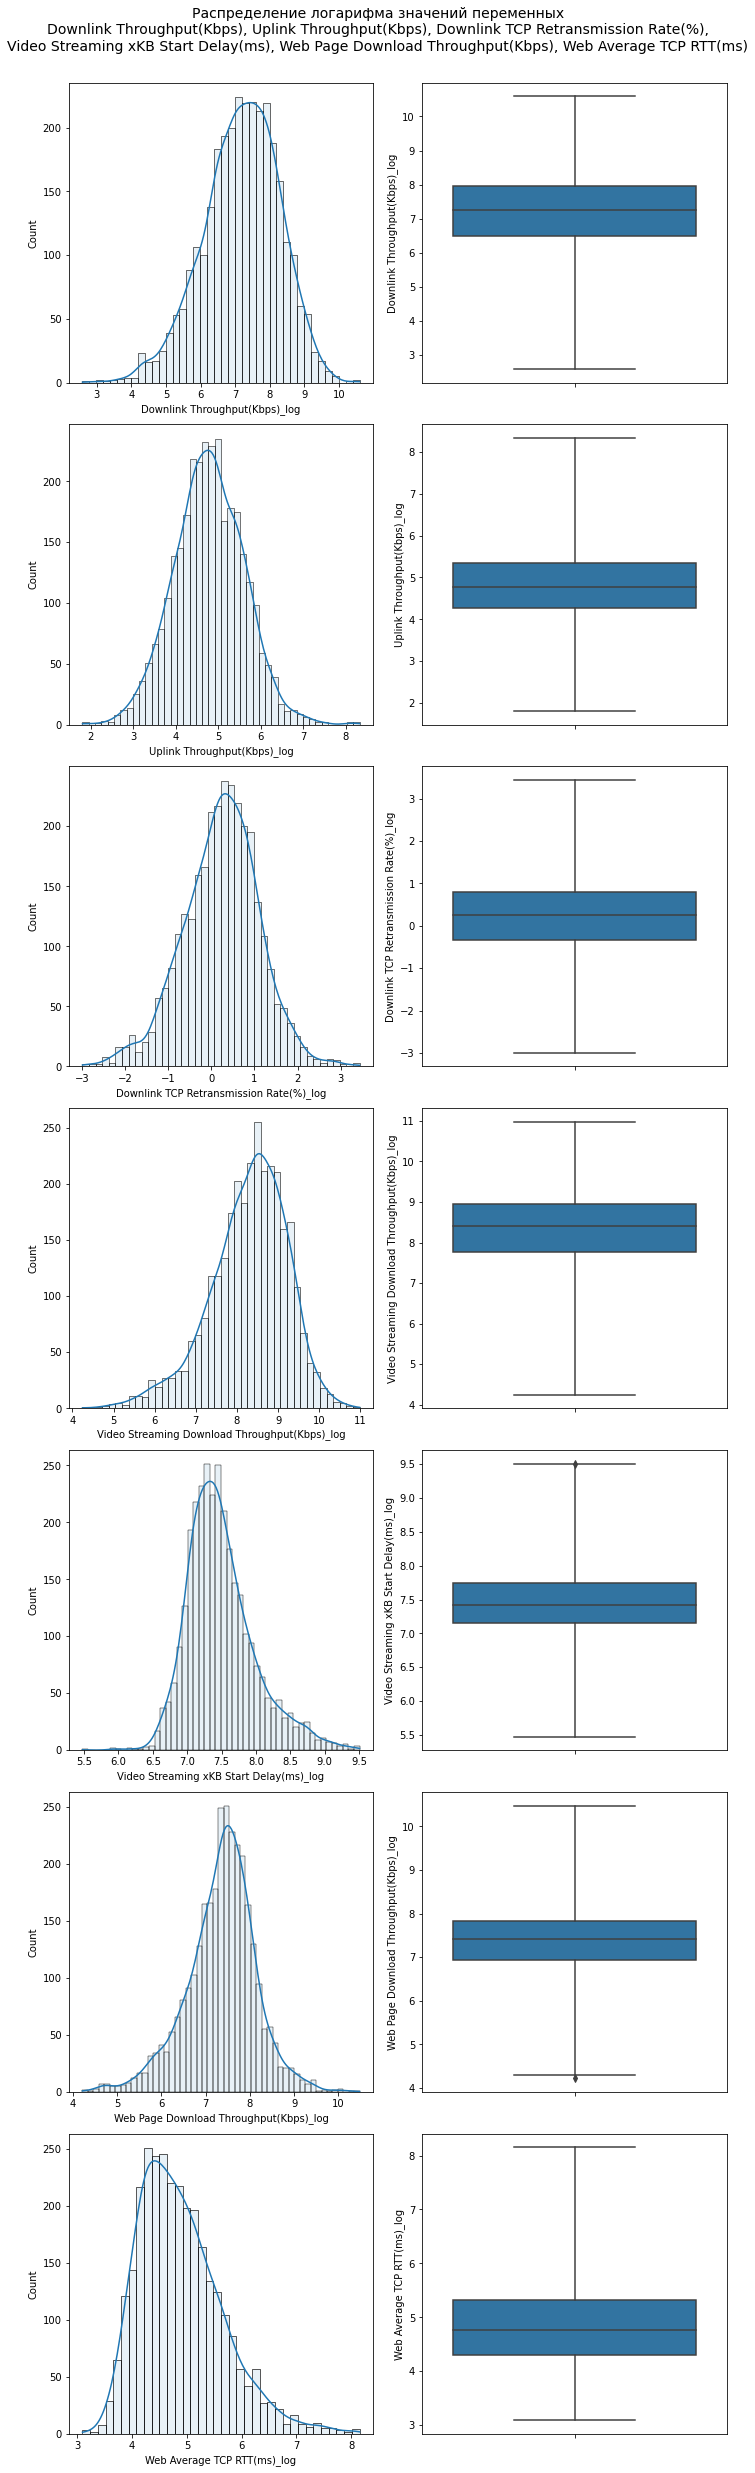

In [23]:
fig, ax = plt.subplots(len(data_columns_log), 2, figsize=(10, 35))
for idx, col in enumerate(data_columns_log):
    sns.histplot(data=df_clean, x=col, ax=ax[idx][0], kde=True, alpha=0.1)
    sns.boxplot(data=df_clean, y=col, ax=ax[idx][1], whis=3)
fig.suptitle(f'Распределение логарифма значений переменных\n{", ".join(data_columns[1:4])},\n{", ".join(data_columns[5:])}', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

Гораздо лучше! Распределения похожи на нормальные, хоть и с визуально меньшей дисперсией.<br>
Попробуем теперь сгенерировать случайные логнормальные распределения, построить функцию ядерной оценки плотности (KDE) случайной переменной и наложить ее на KDE наших данных.

In [24]:
# поскольку мы имеем дело с логнормальным распределением, нам понадобится функция
# для вычисления истинного среднего и дисперсии распределения.
def lognstat(mu, sigma):
    """Calculate the mean of and variance of the lognormal distribution given
    the mean (`mu`) and standard deviation (`sigma`), of the associated normal 
    distribution.
    Taken from: https://stackoverflow.com/questions/10000436/is-there-a-python-method-to-calculate-lognormal-mean-and-variance
    """
    nu = np.exp(mu + sigma**2 / 2.0)
    tau = np.exp(2 * mu + sigma**2) * (np.exp(sigma**2) - 1)
    return nu, tau

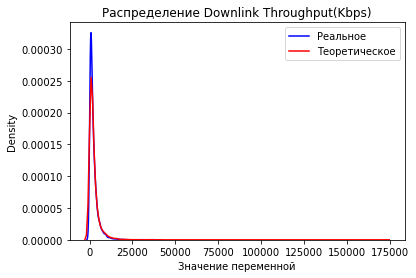

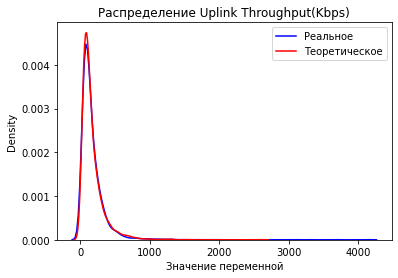

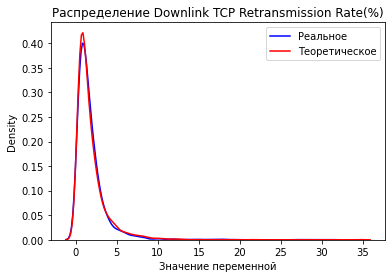

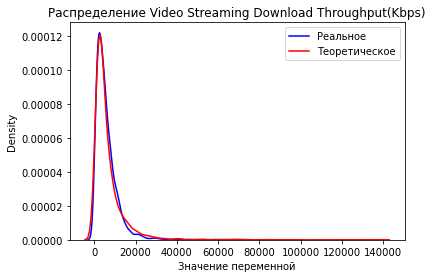

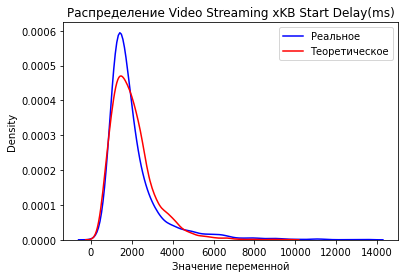

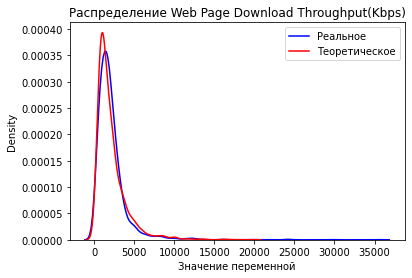

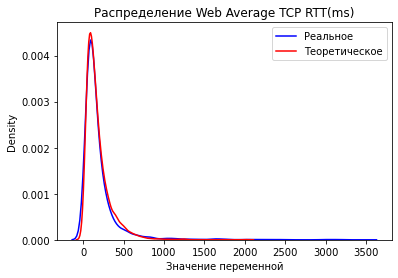

In [25]:
for col in data_columns[1:]:
    samp = df_clean[col].values
    params = sc.stats.lognorm.fit(samp, floc=0)
    theor = sc.stats.lognorm.rvs(*params, size=len(df_clean))
    sns.kdeplot(samp, color='b')
    sns.kdeplot(theor, color='r')
    plt.title(f'Распределение {col}')
    plt.xlabel('Значение переменной')
    plt.legend(['Реальное', 'Теоретическое'])
    plt.show()

Хорошее совпадение. <br>
Теперь попробуем еще раз удостовериться в том, что наше распределение логнормальное.<br>
Класс Fitter библиотеки fitter (https://github.com/cokelaer/fitter) перебирает основные распределения из пакета SciPy, проводит тест и пытается подобрать наиболее подходящие под имеющиеся данные. Пропустим наши данные через этот класс.

In [26]:
from fitter import Fitter, get_common_distributions
results = []
for col in data_columns_log:
    f = Fitter(df_clean[col], timeout=120)
    f.distributions = get_common_distributions()
    f.fit()
    results.append(f)

In [27]:
for idx, r in enumerate(results):
    print(data_columns[1:][idx])
    print(r.summary(plot=False))
    print()

Downlink Throughput(Kbps)
          sumsquare_error         aic           bic  kl_div
norm             0.086067  682.286602 -32267.203561     inf
lognorm          0.089559  687.943209 -32136.724129     inf
gamma            0.106160  693.113563 -31613.153071     inf
chi2             0.116180  702.040305 -31335.432348     inf
exponpow         0.131227  727.482740 -30960.458525     inf

Uplink Throughput(Kbps)
          sumsquare_error         aic           bic  kl_div
norm             0.078358  687.066451 -32556.161853     inf
lognorm          0.079335  681.328669 -32509.970103     inf
gamma            0.079542  681.164164 -32501.919330     inf
exponpow         0.421612  890.016399 -27366.777461     inf
cauchy           0.470017  539.336778 -27040.172335     inf

Downlink TCP Retransmission Rate(%)
          sumsquare_error         aic           bic  kl_div
norm             0.179083  605.490905 -30011.164528     inf
lognorm          0.182614  608.375194 -29943.006801     inf
gamma       

Почти для всех переменных распределение 'norm', т.е. нормальное, дает одну из самых низких ошибок.<br>
Сделаем еще одну проверку. На этот раз построим распределение логарифма занчений и наложим на него график KDE для теоретического нормального распределения с соответствующими средним и стандартным отклонением.<br>
<b>Важно!</b> Т.к. это логнормальное распределение, мы не можем просто взять экспоненту от среднего и дисперсии логарифма значений. Мы должны рассчитать их по формулам:<br>
$$
\nu = e^{\mu + \frac{\sigma^2}{2}}
$$
и
$$
\tau^2 = [e^{\sigma^2}-1]e^{2\mu+\sigma^2}
$$

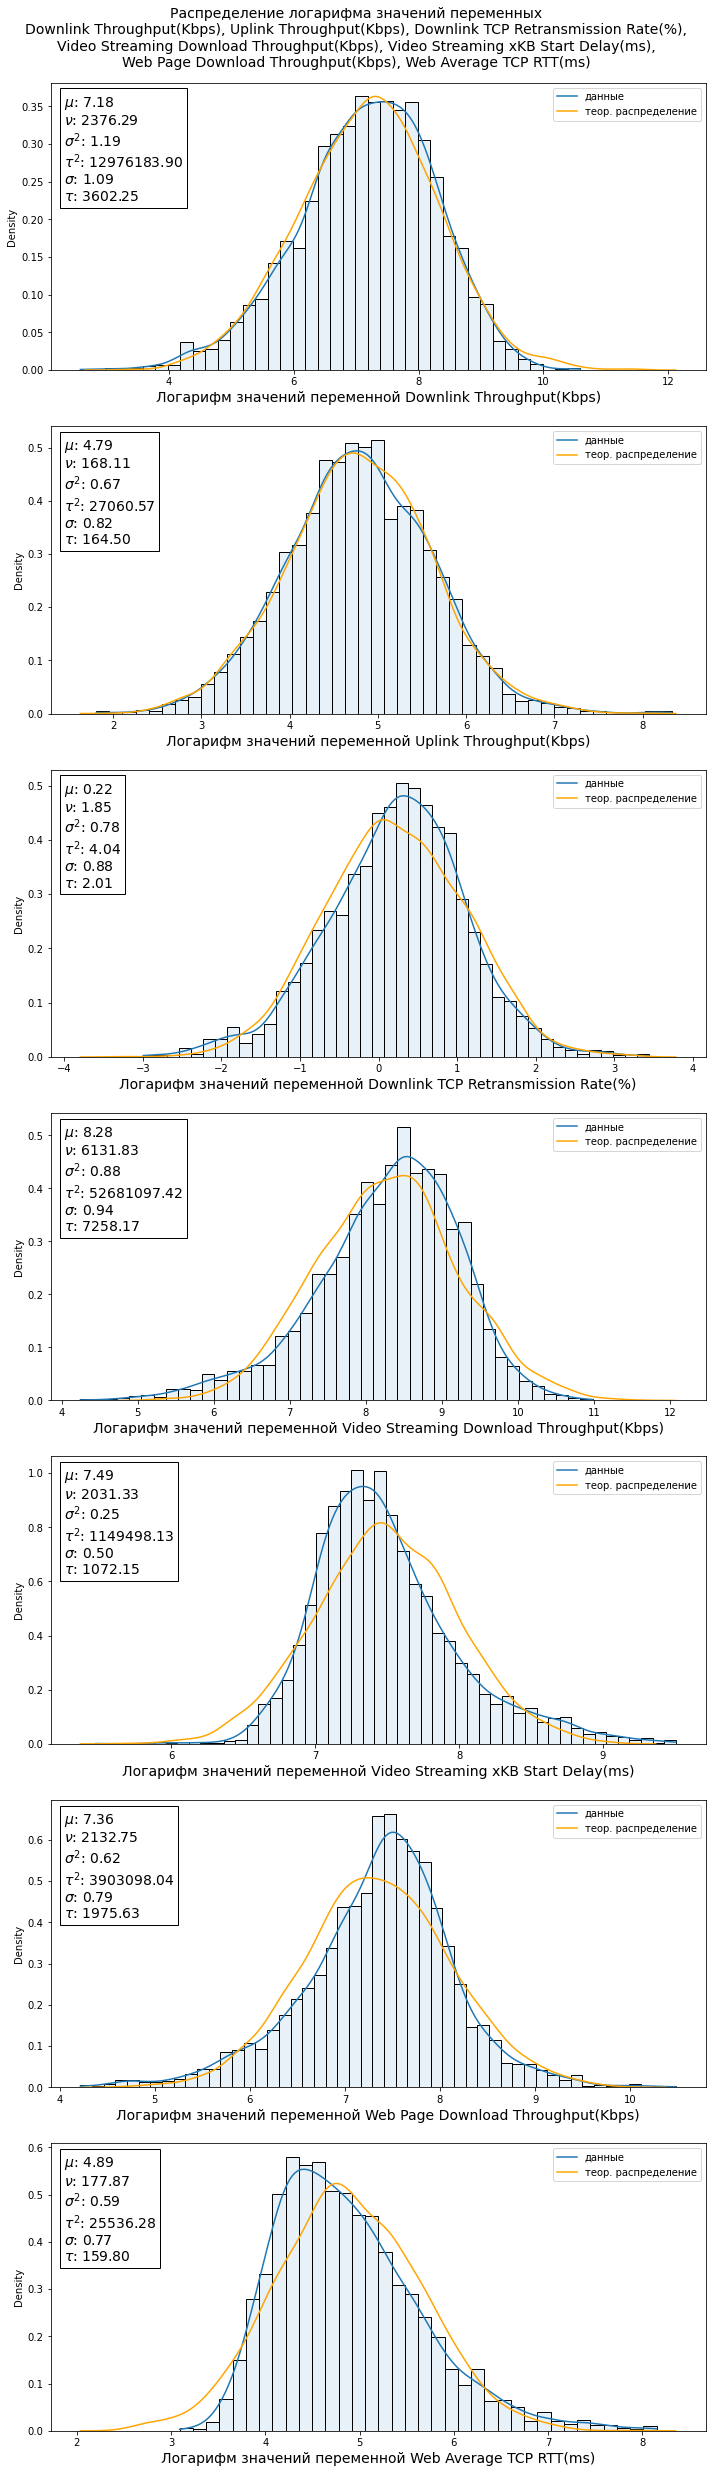

In [28]:
measures = {}
fig, ax = plt.subplots(len(data_columns_log), figsize=(10, 35))
for idx, col in enumerate(data_columns_log):
    sns.histplot(df_clean[col], ax=ax[idx], kde=True, stat='density', alpha=0.1)
    mu = df_clean[col].mean()
    sigma_sq = df_clean[col].var()
    nu, tau_sq = lognstat(mu, np.sqrt(sigma_sq))
    measures[col] = {'mu': mu, 'sigma': sigma_sq, 'nu': nu, 'tau': tau_sq}
    theor = np.random.normal(loc=mu, scale=np.sqrt(sigma_sq), size=len(df_clean[col]))
    sns.kdeplot(theor, ax=ax[idx], color='orange')
    ax[idx].legend(['данные', 'теор. распределение'])
    text = f'$\\mu$: {mu:.2f}\n$\\nu$: {nu:.2f}\n' + \
           f'$\\sigma^2$: {sigma_sq:.2f}\n$\\tau^2$: {tau_sq:.2f}\n' + \
           f'$\\sigma$: {np.sqrt(sigma_sq):.2f}\n$\\tau$: {np.sqrt(tau_sq):.2f}'
    ax[idx].text(0.02, 0.59, text, transform=ax[idx].transAxes,
                fontsize=14, bbox={'lw': 1, 'fill': False})
    ax[idx].set_xlabel(f'Логарифм значений переменной {data_columns[idx + 1]}', fontsize=14)
fig.suptitle(f'Распределение логарифма значений переменных\n{", ".join(data_columns[1:4])},\n{", ".join(data_columns[4:6])},\n{", ".join(data_columns[6:])}', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

По результатам нашего исследования мы можем принять распределение наших переменных за логнормальное.<br>
У нас осталась первая переменная - количество скачанных данных. Попробуем понять, как она распределена. Для этого воспользуемся тем же классом Fitter.

,sumsquare_error,aic,bic,kl_div
exponpow,0.000008,1376.846340,-60673.226954,0.034428
powerlaw,0.000011,1350.358215,-59868.388709,0.031853
gamma,0.000014,1397.563029,-59030.823452,0.054657
chi2,0.000014,1397.563041,-59030.821089,0.054658
expon,0.000015,1405.981081,-58854.365573,0.057955


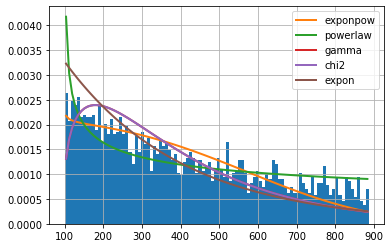

In [29]:
f = Fitter(df_clean[data_columns[0]], timeout=120)
f.distributions = get_common_distributions()
f.fit()
f.summary()

Результаты неоднозначные. Нет какого-либо теоретического распределения, которое подходило бы под наши данные. Скорее всего, нам придется в дальнейшем анализировать эту переменную без каких-либо предположений о типе её распределения.

Перейдем к вопросам. Сначала посмотрим на первый вопрос.<br>
Поскольку градация из 10 ответов слишком детальна для обычного опроса, тем более без критериев, есть смысл проинтерпретировать результаты проще и надежнее: все ответы ниже 9 приравняем к "недоволен/недовольна, есть замечания", а ответы 9 и 10 - "доволен/довольна, замечаний нет".

In [30]:
df_clean['Q1_qual'] = np.where(df_clean['Q1'] > 8, 1, 0)

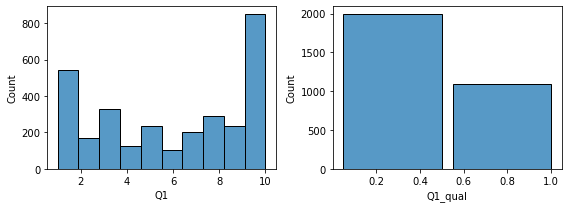

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
sns.histplot(data=df_clean, x='Q1', bins=10, ax=ax[0])
sns.histplot(data=df_clean, x='Q1_qual', bins=2, shrink=0.9, ax=ax[1])
fig.tight_layout()

В два раза больше пользователей говорят нам, что у них есть замечания к качеству связи.<br>
Посмотрим на второй вопрос.

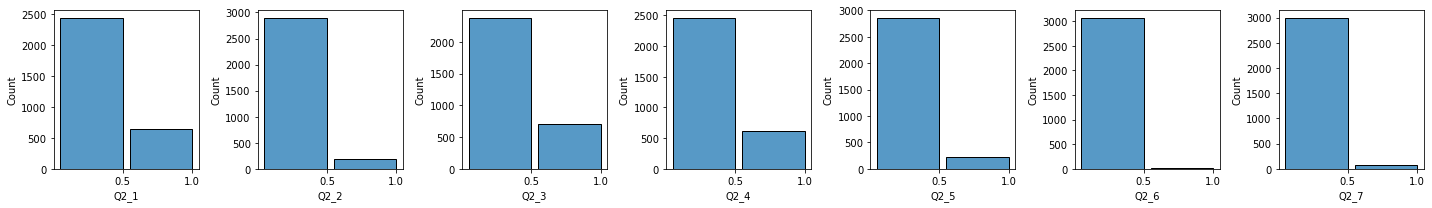

In [32]:
fig, ax = plt.subplots(1, 7, figsize=(20, 3))
for idx, q_col in enumerate(q2_columns[:7]):
    sns.histplot(data=df_clean, x=q_col, bins=2, ax=ax[idx], shrink=0.9)
fig.tight_layout()

Видим, что в абсолютном выражении больше пользователей выбирали варианты (1) Недозвоны, обрывы при звонках; (3) Плохое качество связи в зданиях, торговых центрах и т.п.; и (4) Медленный мобильный интернет - более 500 в каждом случае. Статистическую значимость этих результатов рассмотрим в следующем разделе.

Проверим корреляцию между числовыми показателями. При проверке гипотез для нескольких переменных будет полезно учитывать корреляцию между ними. На график выведем коэффициент корреляции Пирсона $\rho$.

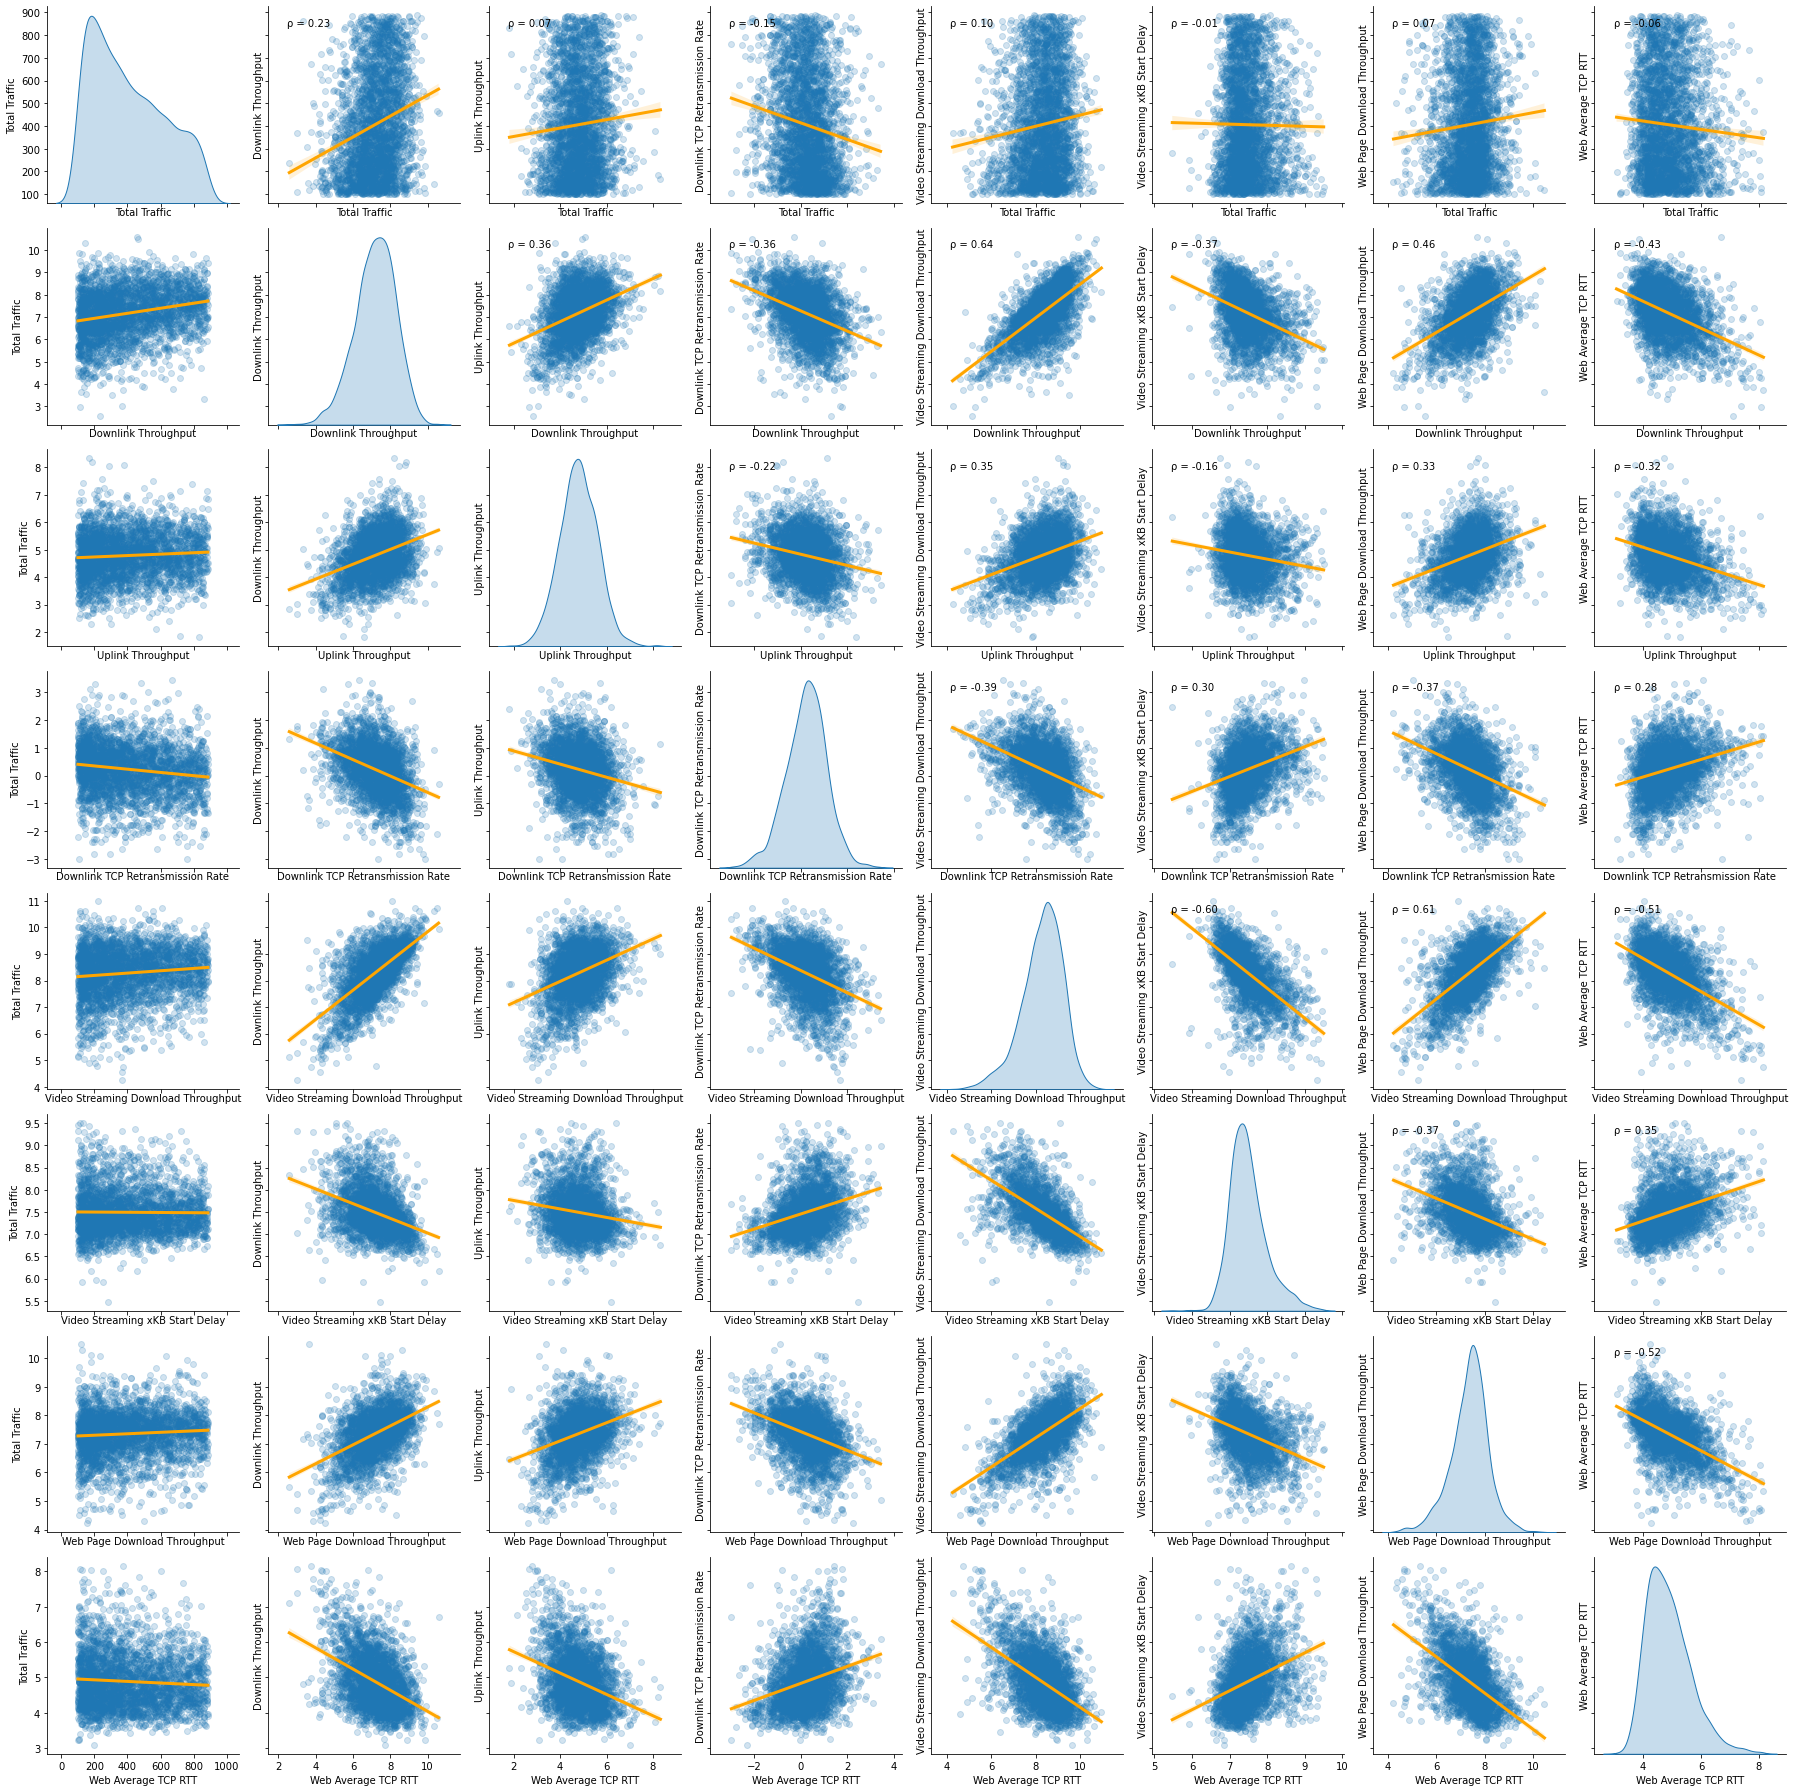

In [33]:
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = sc.stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

g = sns.pairplot(data=df_clean[['Total Traffic(MB)'] + data_columns_log], kind='reg', diag_kind='kde', 
             plot_kws={'line_kws': {'color': 'orange', 'lw': 3}, 
                       'scatter_kws': {'alpha': 0.2}})

g.map_upper(corrfunc)
g.fig.set_size_inches(25,25)
for y in range(g.axes.shape[0]):
    for x in range(g.axes.shape[1]):
        xlabel = data_columns[x][:data_columns[x].find('(')]
        ylabel = data_columns[y][:data_columns[y].find('(')]
        g.axes[x, y].set_xlabel(xlabel)
        g.axes[x, y].set_ylabel(ylabel)
g.fig.tight_layout()

Почти для всех пар данных корреляция варьируется от средней до высокой.<br>

Перейдем к построению гипотез по нашим данным.

### Часть 3. Гипотезы.

#### Гипотеза 1.
<i>Формулировка</i>: пользователи, которые меньше пользуются интернетом для "офисных" целей (почта, мессенджеры, минимум графики и видео), в среднем выше оценивают качество оказываемых услуг.<br>
<i>Для чего</i>: зачатки сегментации пользователей. Если гипотеза подтвердится, мы сможем в дальнейшем а) обосновать необходимость сбора дополнительных данных о наших клиентах для более точной сегментации; б) оценить, какие из сегментов более прибыльные для компании и в зависимости от этого точечно проанализировать их потребности, а значит и дать более эффективную рекомендацию техническому отделу.<br>
<i>Как проверяем</i>: делим переменную `Total Traffic(MB)` на две части в зависимости от ответа на первый вопрос. Нулевая гипотеза: два получившихся распределения между собой не отличаются. Альтернативная гипотеза: между распределениями есть разница. Уровень значимости определим как p = 0.05.<br>
<i>Методика</i>: поскольку мы не смогли точно определить тип переменной `Total Traffic(MB)`, будет проблематично подобрать достоверный статистический тест. Воспользуемся методом перестановок (permutations). Попробуем многократно разделить случайным образом нашу выборку на две части, и сравнить разницу между двумя средними. Таким образом, мы можем сформулировать гипотезы:<br>
$$
H_0: \mu_2 - \mu_1 = 0 \\
H_A: \mu_2 - \mu_1 \ne 0
$$

In [45]:
def permutation_test(data, num, cat, n=1000, dist='norm', mean=0.0, sigma=1.0, two_sided=True, plot=True):
    """
    Finds difference between two distributions.
    
    param data      -- pandas.DataFrame
    param num       -- str; holds the name of the numeric variable which represents the distribution in question.
    param cat       -- str; holds the name of the categorical variable which is used to split the distribution in two.
                       Only supports two categories.
    param n         -- int; number of experiments.
    param dist      -- str; type of the underlying distribution; supports 'norm', 'lognorm'.
    param mean      -- float
    param sigma     -- float
    param two_sided -- bool; check for two-sided or one-sided hypothesis.
    param plot      -- bool; if True, plot the resulting means difference distribution.
    
    returns         -- float; resulting pvalue.
    
    1. Create one joined distribution and sample two new distributions with the length of the original 
    two distributions (grouped by the categorical variable). Repeat n times.
    2. For each iteration, calculate the resulting mean.
    3. Store the means and normalize the distribution of the means.
    4. Calculate the z-score of the original mean difference of two distributions.
    5. Calculate and return the p-value for the original mean difference.
    """
    
    import numpy as np
    import matplotlib.pyplot as plt
    import scipy as sc
    
    len_a, _ = data[cat].value_counts().values
    cat_val_0, cat_val_1 = data[cat].unique()
    if dist == 'norm':
        mean_diff = data[data[cat] == cat_val_0][num].mean() - data[data[cat] == cat_val_1][num].mean()
        means = []
        for _ in range(n):
            perm = np.random.choice(data[num], size=len(data[num]), replace=False)
            perm_a = perm[:len_a]
            perm_b = perm[len_a:]
            means.append(perm_a.mean() - perm_b.mean())
    
    # now find the p-value for diff_mean
    if plot:
        fig, ax = plt.subplots()
        plt.hist(means, bins=len(data[num]) // 100, color='blue', alpha=0.3, edgecolor='black')
        plt.axvline(mean_diff, color='orange', lw=3)
        plt.title(f'Distibution of difference in means for value {num}')
        plt.text(0.02, 0.85, f'Mean difference:\n{mean_diff:.4f}', transform=ax.transAxes, 
                 fontsize=12, bbox={'lw': 1, 'fill': False})
        plt.xlabel('Difference in means')
        plt.ylabel('Count')
        plt.show()
    
    mean_diff_normalized = (mean_diff - np.mean(means)) / np.std(means)
    pvalue = sc.stats.norm.sf(mean_diff_normalized)
    if two_sided:
        pvalue = pvalue * 2
    return pvalue

[2.276166262233801, -13.368828993055956, 0.6415003823943835, 8.762916541113782, -2.1325046337373124, -6.608343051913323, 5.539133904338655, -8.522312165963797, 2.058702153840727, -4.445758833632567, 0.24367830587294748, -6.269946447237942, 0.2278296828297357, 3.991481544180374, 4.836434028598205, 1.6707443486457123, -3.094927669052595, 14.174256652202189, -0.11131682681508437, -3.73984508960865, -0.004736684345516551, 11.088238996648954, -2.4063113234631714, 7.7804970779853875, 5.255237703043122, 13.770977903269, -2.1251210054476815, 3.0496758688571504, -9.76579836662654, 11.647402095710333, -17.69176160736788, 3.9942392440922845, 7.00469842472927, -15.414130886771602, -5.112221976539956, -9.45664679020598, 1.4341802657640983, 7.033142556126052, 4.71584281963186, -6.478674262985692, -9.878030873189118, -1.5680412080012616, -12.859717617710942, -0.8540855909840275, 22.51405882592462, 2.1469661692445925, -7.1238555018649095, 1.7487604875435636, 3.9211379639070856, 14.009419585406874, 3.4

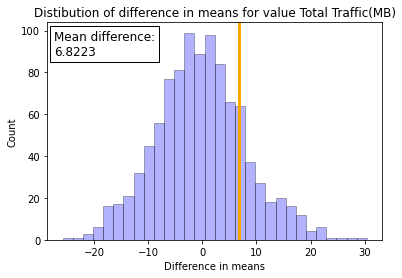

P-value: 0.3922


In [43]:
print(f'P-value: {permutation_test(df_clean, data_columns[0], "Q1_qual"):.4f}')

Получившееся значение p-value говорит о том, что у нас нет оснований отклонить $H_0$, т.е. утверждать, что существует статистически значимая разница между средним значением переменной `Total Traffic(MB)` для пользователей, поставивших высокую или низкую оценку на первый вопрос.

<i>Вывод</i>: наши пользователи в среднем одинаково интенсивно пользуются интернетом: как те, которых устраивает качество услуг, так и те, которые чем-то недовольны. Это означает, что нам нужно рассматривать результаты опроса для всех пользователей одинаково, и не делить пользователей на группы.

#### Гипотеза 2.
<i>Формулировка</i>: пользователи, у которых действительно хорошее качество связи, в среднем ставят более высокую оценку, чем пользователи, у которых качество связи хуже.<br>
<i>Для чего</i>: проверим результаты нашего исследования на достоверность: если вопросы составлены корректно, и результаты тестирования отражают действительность, значит мы можем им доверять.<br>
<i>Как проверяем</i>: у нас есть данные по 7-ми показателям для каждого пользователя (кроме трафика). За "хорошее" качество связи по каждому показателю примем значения выше медианы (в логнормальном выражении), а всё, что ниже - будет считаться "плохим" качеством. Далее просуммируем количество "хороших" показателей для каждого пользователя, и получим среднюю оценку (от 0 до 7). После этого посмотрим, есть ли значимая разница между средней оценкой для довольных и недовольных пользователей.<br>
<i>Методика</i>: т.к. распределение наших оценок по ЦПТ получится близким к нормальному, мы сможем воспользоваться статистическим тестом для проверки гипотезы. Воспользуемся двусторонним критерием Стьюдента (two-sided t-test). За нулевую гипотезу примем, что средние значения оценок для двух групп пользователей одинаковы, а за альтернативную - что они отличаются.<br>
$$
H_0: \mu_1 = \mu_2 \\
H_A: \mu_1 \ne \mu_2
$$

In [36]:
data_columns_log_medians = df_clean[data_columns_log].median().to_dict()
data_columns_log_med_ratings = []
# Поскольку для некоторых показателей больше = лучше, а для некоторых - 
# меньше = лучше, определим для каждой колонки операцию "лучше".
comparisons = ['__ge__', '__ge__', '__lt__', '__ge__', '__lt__', '__ge__', '__lt__']
for col, comp in zip(data_columns_log, comparisons):
    df_clean[col + '_med_rating'] = np.where(getattr(df_clean[col], comp)(data_columns_log_medians[col]), 1, 0)
    data_columns_log_med_ratings.append(col + '_med_rating')
df_clean['Numeric_log_sum_ratings'] = df_clean[data_columns_log_med_ratings].sum(axis=1)
df_clean.drop(data_columns_log_med_ratings, axis=1, inplace=True)

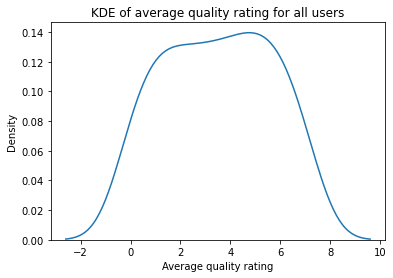

In [37]:
sns.kdeplot(data=df_clean, x='Numeric_log_sum_ratings', bw_adjust=2)
plt.xlabel('Average quality rating')
plt.title('KDE of average quality rating for all users');

Действительно, распределение похоже на нормальное. Небольшой прогиб посередине графика связан с тем, что у нас всего 8 значений.<br>
Теперь посмотрим на распределения по группам клиентов.

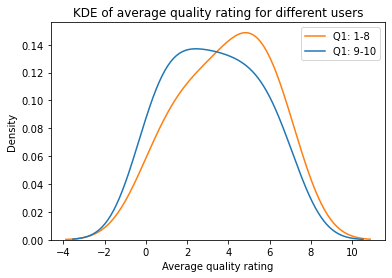

In [38]:
sns.kdeplot(data=df_clean, x='Numeric_log_sum_ratings', hue='Q1_qual', bw_adjust=2.5, common_norm=False);
plt.title('KDE of average quality rating for different users')
plt.xlabel('Average quality rating')
plt.legend(['Q1: 1-8', 'Q1: 9-10']);

Визуально средние двух распределений могут различаться. Проверим, насколько это разлиичие статистически значимо, при помощи критерия Стьюдента.

In [39]:
sc.stats.ttest_ind(df_clean[df_clean['Q1_qual'] == 0]['Numeric_log_sum_ratings'],
                   df_clean[df_clean['Q1_qual'] == 1]['Numeric_log_sum_ratings'])

Ttest_indResult(statistic=-7.470806684043461, pvalue=1.0326724213537646e-13)

Действительно, мы получили значение p-value, близкое к нулю. Это позволяет нам отбросить нулевую гипотезу о том, что средние оценки для двух групп равны.

<i>Вывод</i>: существует статистически достоверная разница между качеством связи для тех пользователей, которые качеством довольны, и для тех, которые недовольны. Это дает нам основания говорить о том, что опрос был проведен правильно и его результатам можно доверять.

#### Гипотеза 3.
<i>Формулировка</i>: Основная задача, которая стояла перед нами в начале исследования - определить, какие из показателей качества связи влияют на мнение пользователей о качестве оказываемых услуг, а следовательно, и на их оценку в опросе. После того, как мы это узнаем, мы сможем передать информацию о самых важных показателях техническим специалистам, чтобы они стали работать над их улучшением.<br>
<i>Для чего</i>: Определив наиболее важные показатели, мы сможем расставить приоритеты для техников, чтобы сфокусироваться на тех показателях, которые имеют наибольшее значение для пользователей.<br>
<i>Как проверяем</i>: мы уже установили, что у пользователей, у которых нет замечаний к качеству связи, в среднем качество лучше. Поэтому в этот раз мы сфокусируемся на тех пользователях, которые недовольны качеством. Поскольку наши пользователи чаще жалуются на недозвоны и обрывы, плохое качество связи в зданиях и медленный мобильный интернет, мы будем анализировать данные по тем пользователям, которые выбрали эти варианты ответа на второй вопрос.<br>
<i>Методика</i>: <br>